# WiFi Fingerprint Localization: Predicting Position and Floor from RSSI Fingerprints

#### Dataset: The UJIIndoorLoc is a Multi-Building Multi-Floor indoor localization database to test Indoor Positioning System that rely on WiFi fingerprints. 

#### Goal: Predict the longitude, latitude, and altitude of the RSSI fingerprints (regression) as well as building and floor (classification).


In [56]:
#Importing 
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBRegressor, XGBClassifier
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict


##### Step 1: Loading Data

In [57]:
train_df = pd.read_csv('trainingData.csv')
validation_df = pd.read_csv('validationData.csv')

##### Step 2: Exploring Data

In [58]:
#viewing descriptive stats., info, and shape (train)
print(f"Shape of training data: {train_df.shape}")
train_df.info()
train_df.describe() 


Shape of training data: (19937, 529)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19937 entries, 0 to 19936
Columns: 529 entries, WAP001 to TIMESTAMP
dtypes: float64(2), int64(527)
memory usage: 80.5 MB


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,19937.000000,19937.000000,19937.0,19937.0,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,...,19937.0,19937.000000,1.993700e+04,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,1.993700e+04
mean,99.823644,99.820936,100.0,100.0,99.613733,97.130461,94.733661,93.820234,94.693936,99.163766,...,100.0,-7464.275947,4.864871e+06,1.674575,1.212820,148.429954,1.833024,9.068014,13.021869,1.371421e+09
std,5.866842,5.798156,0.0,0.0,8.615657,22.931890,30.541335,33.010404,30.305084,12.634045,...,0.0,123.402010,6.693318e+01,1.223078,0.833139,58.342106,0.372964,4.988720,5.362410,5.572054e+05
min,-97.000000,-90.000000,100.0,100.0,-97.000000,-98.000000,-99.000000,-98.000000,-98.000000,-99.000000,...,100.0,-7691.338400,4.864746e+06,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.369909e+09
25%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7594.737000,4.864821e+06,1.000000,0.000000,110.000000,2.000000,5.000000,8.000000,1.371056e+09
50%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7423.060900,4.864852e+06,2.000000,1.000000,129.000000,2.000000,11.000000,13.000000,1.371716e+09
75%,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7359.193000,4.864930e+06,3.000000,2.000000,207.000000,2.000000,13.000000,14.000000,1.371721e+09
max,100.000000,100.000000,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.0,-7300.818990,4.865017e+06,4.000000,2.000000,254.000000,2.000000,18.000000,24.000000,1.371738e+09


In [59]:
#Viewing first 5 rows of train df
print("First Look at Training Data (First 5 rows):")
train_df.head()

First Look at Training Data (First 5 rows):


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [60]:
#viewing descriptive stats., info, and shape (validation)
print(f"Shape of validation data: {validation_df.shape}")
validation_df.info()
validation_df.describe()

Shape of validation data: (1111, 529)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Columns: 529 entries, WAP001 to TIMESTAMP
dtypes: float64(2), int64(527)
memory usage: 4.5 MB


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,1111.000000,1111.0,1111.000000,1111.000000,1111.0,1111.0,1111.0,1111.000000,1111.000000,1111.000000,...,1111.000000,1111.000000,1.111000e+03,1111.000000,1111.000000,1111.0,1111.0,1111.0,1111.000000,1.111000e+03
mean,98.627363,100.0,99.665167,99.665167,100.0,100.0,100.0,94.297030,90.655266,98.811881,...,99.843384,-7529.197448,4.864902e+06,1.571557,0.758776,0.0,0.0,0.0,11.923492,1.380604e+09
std,16.127245,0.0,7.888265,7.888607,0.0,0.0,0.0,32.148809,39.886991,14.931667,...,5.220261,120.209336,7.027280e+01,1.001828,0.816139,0.0,0.0,0.0,6.556236,5.003222e+05
min,-94.000000,100.0,-87.000000,-88.000000,100.0,100.0,100.0,-99.000000,-96.000000,-98.000000,...,-74.000000,-7695.938755,4.864748e+06,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.379578e+09
25%,100.000000,100.0,100.000000,100.000000,100.0,100.0,100.0,100.000000,100.000000,100.000000,...,100.000000,-7637.423800,4.864843e+06,1.000000,0.000000,0.0,0.0,0.0,9.000000,1.380189e+09
50%,100.000000,100.0,100.000000,100.000000,100.0,100.0,100.0,100.000000,100.000000,100.000000,...,100.000000,-7560.376300,4.864915e+06,1.000000,1.000000,0.0,0.0,0.0,13.000000,1.380873e+09
75%,100.000000,100.0,100.000000,100.000000,100.0,100.0,100.0,100.000000,100.000000,100.000000,...,100.000000,-7420.539659,4.864967e+06,2.000000,1.000000,0.0,0.0,0.0,15.000000,1.380875e+09
max,100.000000,100.0,100.000000,100.000000,100.0,100.0,100.0,100.000000,100.000000,100.000000,...,100.000000,-7299.786517,4.865017e+06,4.000000,2.000000,0.0,0.0,0.0,21.000000,1.381248e+09


In [61]:
#Viewing first 5 rows of validation df 
print("First Look at Validation Data (First 5 rows):")
validation_df.head()

First Look at Validation Data (First 5 rows):


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7515.916799,4.864890e+06,1,1,0,0,0,0,1380872703
1,100,100,100,100,100,100,100,100,100,100,...,100,-7383.867221,4.864840e+06,4,2,0,0,0,13,1381155054
2,100,100,100,100,100,100,100,100,100,100,...,100,-7374.302080,4.864847e+06,4,2,0,0,0,13,1381155095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7365.824883,4.864843e+06,4,2,0,0,0,13,1381155138
4,100,100,100,100,100,100,100,100,100,100,...,100,-7641.499303,4.864922e+06,2,0,0,0,0,2,1380877774


In [62]:
#missing value checks (will have to look fro values=100 instead of missing too )
total_missing_train = train_df.isnull().sum().sum()
total_missing_val = validation_df.isnull().sum().sum() 

print(f"\nTotal missing values in the Training DataFrame: {total_missing_train}")
print(f"\nTotal missing values in the Validation DataFrame: {total_missing_val}")


Total missing values in the Training DataFrame: 0

Total missing values in the Validation DataFrame: 0


In [63]:
#Checking how many RSSI signal features 
count_signals_train = train_df.columns.str.contains('AP').sum()
count_signals_val = validation_df.columns.str.contains('AP').sum()

print(f"Number of RSSI Signals as Features in Training: {count_signals_train}")
print(f"Number of RSSI Signals as Features in Validation: {count_signals_val}")

Number of RSSI Signals as Features in Training: 520
Number of RSSI Signals as Features in Validation: 520


In [64]:
#Printing Col. names to see what we have to remove and making sure both csv files line up
train_column_names = train_df.columns.tolist()
print(train_column_names)

val_column_names = validation_df.columns.tolist()
print(val_column_names)

['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006', 'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012', 'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018', 'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024', 'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030', 'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036', 'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042', 'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048', 'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054', 'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060', 'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066', 'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072', 'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078', 'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084', 'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP090', 'WAP091', 'WAP092', 'WAP093', 'WAP094', 'WAP095', 'WAP096', 'WAP097', 'WAP098', 'WAP099', 'WAP100',

##### Step 3: Preprocessing Data (Train Test Split, Scaling, Dimensionality Reduction)

In [65]:
#Idenitfyng modeling columns 
wap_cols = [c for c in train_df.columns if c.startswith("WAP")]

#Targets
regression_targets = ['LONGITUDE', 'LATITUDE', 'FLOOR']  # using FLOOR as altitude proxy
building_target = 'BUILDINGID'
floor_target    = 'FLOOR'

#Meta data we DO NOT want as features 
meta_cols = ['SPACEID', 'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP']

In [66]:
#count total number of 100 values in all RSSI columns
#100 = no signal because impossible in RSSI (would imply an impossible wildly strong signal)
#high counts of 100 mean noisy features 
total_no_signal = (train_df[wap_cols] == 100).sum().sum()
print(f"Total no-signal (100) values in dataset: {total_no_signal:,}")

#Replacing 100 with -105 in all WAP col. because -105 implies too weak to be real 
#altering the original dataframes 
#model will now treat the no signal as just extremely weak
for df in (train_df, validation_df):
    df[wap_cols] = df[wap_cols].replace(100, -105)

Total no-signal (100) values in dataset: 10,008,477


In [67]:
#Building X and y for regression and classification 

#Same X for all models
X_train = train_df[wap_cols]
X_val = validation_df[wap_cols]

#Different y depending on task
y_train_reg = train_df[regression_targets]
y_val_reg  = validation_df[regression_targets]

y_train_building = train_df[building_target]
y_val_building = validation_df[building_target]

y_train_floor = train_df[floor_target]
y_val_floor = validation_df[floor_target]

In [68]:
#checking class balance
print("Building class counts:")
print(y_train_building.value_counts())

print("\nBuilding class percentages:")
print(y_train_building.value_counts(normalize=True) * 100)

print("\nFloor class counts:")
print(y_train_floor.value_counts())

print("\nFloor class percentages:")
print(y_train_floor.value_counts(normalize=True) * 100)


Building class counts:
BUILDINGID
2    9492
0    5249
1    5196
Name: count, dtype: int64

Building class percentages:
BUILDINGID
2    47.609971
0    26.327933
1    26.062096
Name: proportion, dtype: float64

Floor class counts:
FLOOR
3    5048
1    5002
2    4416
0    4369
4    1102
Name: count, dtype: int64

Floor class percentages:
FLOOR
3    25.319757
1    25.089030
2    22.149772
0    21.914029
4     5.527411
Name: proportion, dtype: float64


In [69]:
#scaling the data 
scaler = StandardScaler()

#fit on train WAP features only
X_train_scaled = scaler.fit_transform(X_train)

#transform validtaion with same scaler
X_val_scaled = scaler.transform(X_val)

In [70]:
#Removing low variance WAPs: if a WAP never detected a signal (always -105) then it is useless 
selector = VarianceThreshold(threshold=0.01)

#only the columns with variation are kept in the new reduced feature matrix
X_train_var = selector.fit_transform(X_train_scaled)
X_val_var = selector.transform(X_val_scaled)

#Checking how many were kept 
original = X_train_scaled.shape[1]
reduced  = X_train_var.shape[1]

print(f"Original WAPs: {original}")
print(f"Remaining after variance filtering: {reduced}")
print(f"Dropped WAPs: {original - reduced}")

Original WAPs: 520
Remaining after variance filtering: 465
Dropped WAPs: 55


In [71]:
#PCA Dimensionality Reduction on already reduced feature set
#especially helpfulf or KNN ad NN

#dataset likely needs almost all componenets to explain 95% variance so all features were kept
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_var)
X_val_pca = pca.transform(X_val_var)

pca_reduced  = X_train_pca.shape[1]
print(f"Remaining after PCA Dimensionality Reduction: {X_train_pca.shape[1]}")

#Setting fixed numebr of components
for n in [300, 200, 100, 60, 30]:
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_var)
    print(f"Components: {n} → explained variance = {sum(pca.explained_variance_ratio_):.3f}")

Remaining after PCA Dimensionality Reduction: 262
Components: 300 → explained variance = 0.971
Components: 200 → explained variance = 0.893
Components: 100 → explained variance = 0.711
Components: 60 → explained variance = 0.595
Components: 30 → explained variance = 0.463


In [72]:
#Picking 200 componenets for higher accuracy 
#If you wanted faster model and good performance then use 100 components 
#context is important for determining the trade-off you would like to select
#Choosing PCA dimension
pca = PCA(n_components=200)      
X_train_pca = pca.fit_transform(X_train_var)
X_val_pca   = pca.transform(X_val_var)

##### Step 4: Baseline Modeling (KNN and RandomForest)


In [73]:
#KNN Regression Baseline 
knn_reg = KNeighborsRegressor(
    n_neighbors=5, 
    weights='distance', 
    n_jobs=-1
)

knn_reg.fit(X_train_pca, y_train_reg)
y_pred_reg = knn_reg.predict(X_val_pca)

mae_long = mean_absolute_error(y_val_reg['LONGITUDE'], y_pred_reg[:,0])
mae_lat  = mean_absolute_error(y_val_reg['LATITUDE'],  y_pred_reg[:,1])
mae_floor = mean_absolute_error(y_val_reg['FLOOR'],    y_pred_reg[:,2])

print("KNN Regression Baseline: ")
print(f"MAE Longitude : {mae_long:.3f}")
print(f"MAE Latitude  : {mae_lat:.3f}")
print(f"MAE Floor     : {mae_floor:.3f}")


KNN Regression Baseline: 
MAE Longitude : 7.450
MAE Latitude  : 7.347
MAE Floor     : 0.219


In [74]:
#Random Forest Building Classification Baseline 
rf_building = RandomForestClassifier(n_estimators=200,random_state=42,n_jobs=-1)

rf_building.fit(X_train_pca, y_train_building)
build_pred = rf_building.predict(X_val_pca)

print("\nRandom Forest Baseline: Building Classification: ")
print(f"Accuracy: {accuracy_score(y_val_building, build_pred):.3f}")
print(classification_report(y_val_building, build_pred))


Random Forest Baseline: Building Classification: 
Accuracy: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       536
           1       1.00      1.00      1.00       307
           2       1.00      1.00      1.00       268

    accuracy                           1.00      1111
   macro avg       1.00      1.00      1.00      1111
weighted avg       1.00      1.00      1.00      1111



In [75]:
set(wap_cols) & set(['FLOOR','BUILDINGID','LONGITUDE','LATITUDE'])
print(X_train_pca.shape)
print(X_train.shape)
print(train_df.columns)

(19937, 200)
(19937, 520)
Index(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006', 'WAP007',
       'WAP008', 'WAP009', 'WAP010',
       ...
       'WAP520', 'LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'SPACEID',
       'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP'],
      dtype='object', length=529)


In [76]:
#Random Forest Floor Classification Baseline
rf_floor = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_floor.fit(X_train_pca, y_train_floor)
floor_pred = rf_floor.predict(X_val_pca)


print("\nRandom Forest: Floor Classification: ")
print(f"Accuracy: {accuracy_score(y_val_floor, floor_pred):.3f}")
print(classification_report(y_val_floor, floor_pred))


Random Forest: Floor Classification: 
Accuracy: 0.842
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       132
           1       0.95      0.83      0.89       462
           2       0.73      0.90      0.80       306
           3       0.77      0.82      0.79       172
           4       1.00      0.64      0.78        39

    accuracy                           0.84      1111
   macro avg       0.87      0.81      0.83      1111
weighted avg       0.86      0.84      0.84      1111



##### Step 5: Cross-Validation for Baseline Reliability Check

In [77]:

cv = KFold(n_splits=5, shuffle=True, random_state=42)

#CV: Building classification (RF) with no leakage
rf_building = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

pipe_building = Pipeline([
    ("scaler", StandardScaler()),
    ("vt", VarianceThreshold(threshold=0.01)),
    ("pca", PCA(n_components=200)),
    ("model", rf_building)
])

rf_cv_scores = cross_val_score(pipe_building, X_train, y_train_building, cv=cv, n_jobs=-1)

print("\n--- Cross-Validation: Building Classification ---")
print(f"Mean Accuracy: {rf_cv_scores.mean():.4f}")
print(f"Std Dev      : {rf_cv_scores.std():.4f}")

#CV: Regression (KNN) with no leakage
knn_reg = KNeighborsRegressor(n_neighbors=5, weights="distance", n_jobs=-1)

pipe_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("vt", VarianceThreshold(threshold=0.01)),
    ("pca", PCA(n_components=200)),
    ("model", knn_reg)
])

y_pred_cv = cross_val_predict(pipe_reg, X_train, y_train_reg, cv=cv, n_jobs=-1)

mae_long_cv = mean_absolute_error(y_train_reg['LONGITUDE'], y_pred_cv[:,0])
mae_lat_cv  = mean_absolute_error(y_train_reg['LATITUDE'],  y_pred_cv[:,1])
mae_floor_cv = mean_absolute_error(y_train_reg['FLOOR'],    y_pred_cv[:,2])

print("\n--- Cross-Validation: Regression ---")
print(f"Longitude MAE: {mae_long_cv:.3f}")
print(f"Latitude  MAE: {mae_lat_cv:.3f}")
print(f"Floor     MAE: {mae_floor_cv:.3f}")



--- Cross-Validation: Building Classification ---
Mean Accuracy: 0.9979
Std Dev      : 0.0006

--- Cross-Validation: Regression ---
Longitude MAE: 2.166
Latitude  MAE: 1.883
Floor     MAE: 0.022


##### Step 6: Adding More Models + Model Comparison Table

In [78]:
#Regression Model comparison (KNN, RF, XGBOOST)
#Comparing MAE for longitude, latitude, and floor 

reg_models = {
    "KNN Regressor": KNeighborsRegressor(
        n_neighbors=5,
        weights='distance',
        n_jobs=-1
    ),
    "Random Forest Regressor": RandomForestRegressor(
        n_estimators=300,
        n_jobs=-1,
        random_state=42
    ),
    "XGBoost Regressor": MultiOutputRegressor(
        XGBRegressor(
            tree_method="hist",
            n_estimators=300,
            max_depth=8,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            n_jobs=-1,
            random_state=42
        )
    )
}

reg_results = []

for name, model in reg_models.items():
    print(f"Training {name}...")
    model.fit(X_train_pca, y_train_reg) # multi-output: LONG, LAT, FLOOR
    pred = model.predict(X_val_pca)

    mae_long  = mean_absolute_error(y_val_reg["LONGITUDE"], pred[:, 0])
    mae_lat   = mean_absolute_error(y_val_reg["LATITUDE"],  pred[:, 1])
    mae_floor = mean_absolute_error(y_val_reg["FLOOR"],     pred[:, 2])

    reg_results.append([name, mae_long, mae_lat, mae_floor])

reg_table = pd.DataFrame(
    reg_results,
    columns=["Model", "MAE_Longitude", "MAE_Latitude", "MAE_Floor"]
)

print("\n--- Regression Comparison Table ---")
print(reg_table)


Training KNN Regressor...
Training Random Forest Regressor...
Training XGBoost Regressor...

--- Regression Comparison Table ---
                     Model  MAE_Longitude  MAE_Latitude  MAE_Floor
0            KNN Regressor       7.449597      7.346908   0.219040
1  Random Forest Regressor       6.462164      5.912928   0.365392
2        XGBoost Regressor       6.723203      5.957405   0.235590


In [79]:
#Classification Building Model comparison (KNN, RF, XGBOOST)

class_models_building = {
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        n_jobs=-1,
        random_state=42
    ),
    "KNN Classifier": KNeighborsClassifier(
        n_neighbors=5,
        weights='distance',
        n_jobs=-1
    ),
    "XGBoost Classifier": XGBClassifier(
        tree_method="hist",
        n_estimators=300,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42
    )
}

class_results_building = []

for name, model in class_models_building.items():
    print(f"Training {name} for BUILDINGID...")
    model.fit(X_train_pca, y_train_building)
    pred = model.predict(X_val_pca)
    acc = accuracy_score(y_val_building, pred)
    class_results_building.append([name, acc])

class_table_building = pd.DataFrame(
    class_results_building,
    columns=["Model", "Accuracy (Building)"]
)

print("\n--- Building Classification Comparison Table ---")
print(class_table_building)



Training Random Forest for BUILDINGID...
Training KNN Classifier for BUILDINGID...
Training XGBoost Classifier for BUILDINGID...

--- Building Classification Comparison Table ---
                Model  Accuracy (Building)
0       Random Forest             1.000000
1      KNN Classifier             0.990999
2  XGBoost Classifier             0.997300


In [80]:
#Classification Floor Comparison (RF, KNN, XGBoost)

class_models_floor = {
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        n_jobs=-1,
        random_state=42
    ),
    "KNN Classifier": KNeighborsClassifier(
        n_neighbors=5,
        weights='distance',
        n_jobs=-1
    ),
    "XGBoost Classifier": XGBClassifier(
        tree_method="hist",
        n_estimators=300,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42
    )
}

floor_results = []

for name, model in class_models_floor.items():
    print(f"Training {name} for FLOOR...")
    model.fit(X_train_pca, y_train_floor)
    pred = model.predict(X_val_pca)
    acc = accuracy_score(y_val_floor, pred)
    floor_results.append([name, acc])

floor_table = pd.DataFrame(
    floor_results,
    columns=["Model", "Accuracy (Floor)"]
)

print("\n--- Floor Classification Comparison Table ---")
print(floor_table)


Training Random Forest for FLOOR...
Training KNN Classifier for FLOOR...
Training XGBoost Classifier for FLOOR...

--- Floor Classification Comparison Table ---
                Model  Accuracy (Floor)
0       Random Forest          0.846085
1      KNN Classifier          0.823582
2  XGBoost Classifier          0.879388


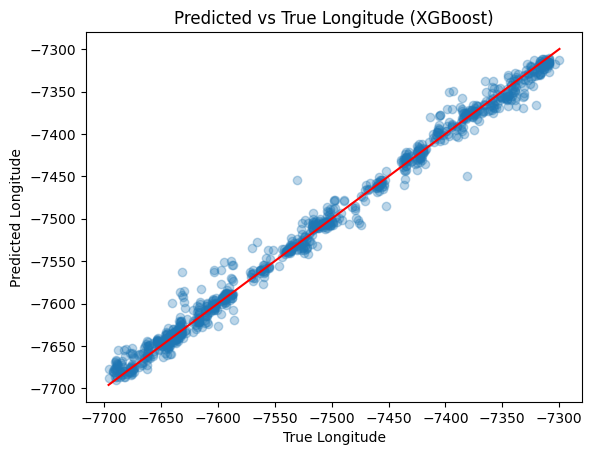

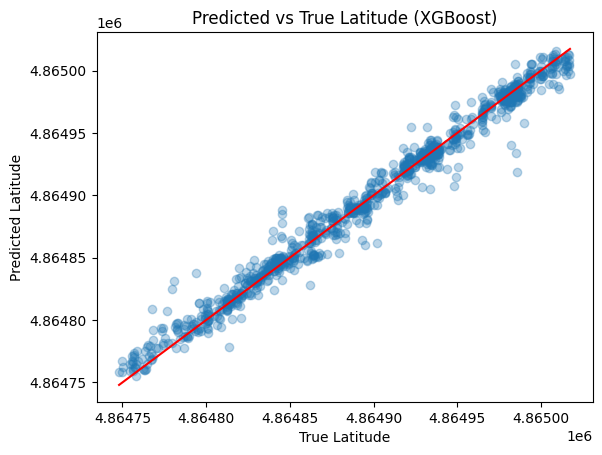

In [81]:
#Refit best regression model (XGBoost) on full train PCA set
best_reg = reg_models["XGBoost Regressor"]
best_reg.fit(X_train_pca, y_train_reg)
y_pred_best = best_reg.predict(X_val_pca)

#Longitude plot
plt.figure()
plt.scatter(y_val_reg['LONGITUDE'], y_pred_best[:, 0], alpha=0.3)
min_long = min(y_val_reg['LONGITUDE'].min(), y_pred_best[:, 0].min())
max_long = max(y_val_reg['LONGITUDE'].max(), y_pred_best[:, 0].max())
plt.plot([min_long, max_long], [min_long, max_long], 'r')
plt.xlabel("True Longitude")
plt.ylabel("Predicted Longitude")
plt.title("Predicted vs True Longitude (XGBoost)")
plt.show()

#Latitude plot
plt.figure()
plt.scatter(y_val_reg['LATITUDE'], y_pred_best[:, 1], alpha=0.3)
min_lat = min(y_val_reg['LATITUDE'].min(), y_pred_best[:, 1].min())
max_lat = max(y_val_reg['LATITUDE'].max(), y_pred_best[:, 1].max())
plt.plot([min_lat, max_lat], [min_lat, max_lat], 'r')
plt.xlabel("True Latitude")
plt.ylabel("Predicted Latitude")
plt.title("Predicted vs True Latitude (XGBoost)")
plt.show()
